# Segmenting and Clustering Popular Cities in Poland

In this notebook, we will take a closer look at 4 different cities in Poland; Łódź, Warsaw, Kraków and Poznań. We will compare those cities based on the most common venues categories of each city. 
First, we need to segment each city in multiple location points. Therefore, we need to define the maximum radius for each location point. Second, we will get the most common venues categories for each location point using the Foursquare API. Then, we will use this feature to group the location points into clusters using the *k*-means clustering algorithm. Finally, we will use the Folium library to visualize the location point of each city and their emerging clusters.

Before we get the started, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

from collections import Counter

from scipy.spatial.distance import cdist

print('Libraries imported.')

Libraries imported.


## 1. Define the maximum radius

We want to have the data of multiple venues for each city. Unfortunately, the Foursquare API allows to get a maximum of only 100 venues per location. Therefore, we need to create multiple location points within the city.
Before we can do this, we need to determine at what radius the maximum of 100 venues is returned. Based on this information, we can segment the city and create multiple location points. So let's create a function that determines the amount of venues within in a certain radius using the Foursquare API.

In [2]:
def get_venues(city, radius=1000, LIMIT=100):
            
    # Define the required information to acces the Foursquare database
    CLIENT_ID = 'YLLS0M41W50WQL00PHXCZ0EBM24NGYQO5D4QLBCUX1TUAHPI' # my Foursquare ID
    CLIENT_SECRET = 'REIOKDT0Z5TNR33QH2BHYE20V0LJPUXG3DZTIZ5U1U4CIN0E' # my Foursquare Secret
    VERSION = '20180605' # Foursquare API version
        
    # Create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        city[0], 
        city[1],
        radius, 
        LIMIT)
    
    # Get the data of the venues from the API
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']   
    nearby_venues = json_normalize(venues)
    
    # Return the number of nearby venues
    return([len(nearby_venues)])

Now we have to get the amount of venues, when we vary the radius. So we can plot it and determine the maximum. 

In [3]:
# Give the coordinates of each city retrieved with Google Maps
lodz = [51.765542, 19.457162]
krakow = [50.060585, 19.937697]
poznan = [52.406362, 16.925152]
warsaw = [52.232779, 21.010328]
# Remark: The coordinates are of the city centre and seemed to have the most nearby venues

# Vary the radius and get the corresponding amount of venues for each radius
radius = list(np.arange(300,550,10))
venues_lo =[]
venues_kr =[]
venues_po =[]
venues_wa =[]
for ii in radius:
    number_of_venues_lo = get_venues(lodz, radius=radius)
    venues_lo = venues_lo + number_of_venues_lo
    number_of_venues_kr = get_venues(krakow, radius=radius)
    venues_kr = venues_kr + number_of_venues_kr
    number_of_venues_po = get_venues(poznan, radius=radius)
    venues_po = venues_po + number_of_venues_po
    number_of_venues_wa = get_venues(warsaw, radius=radius)
    venues_wa = venues_wa + number_of_venues_wa

Note: If the function does not work, the maximum amount of calls that can be made to the Foursquare API is exceeded.

Let's create a text box that shows at what radius the limit of 100 venues is reached.

In [4]:
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)] # The radius when the maximum amount of venues is reached
    text= "r="+ str(xmax)  # The text to show in the text box
    ymax = max(y)
    if not ax:
        ax=plt.gca()
        
    # The properties of the text box
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="left", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.20,0.90), **kw)

Now we can create the plot for each city, which shows at what radius the limit of 100 venues is reached.

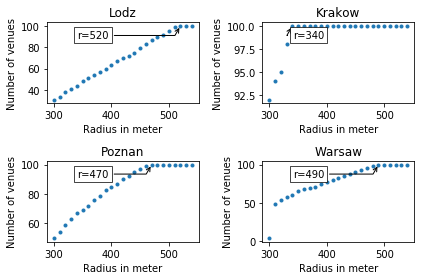

In [5]:
# Create a figure with subplots for every city
fig = plt.figure()

# Lodz
plt.subplot(2, 2, 1)
plt.plot(radius, venues_lo,'.')
annot_max(radius, venues_lo)
plt.xlabel('Radius in meter')
plt.ylabel('Number of venues')
plt.title('Lodz')

# Krakow
plt.subplot(2, 2, 2)
plt.plot(radius, venues_kr, '.')
annot_max(radius, venues_kr)
plt.xlabel('Radius in meter')
plt.ylabel('Number of venues')
plt.title('Krakow')

# Poznan
plt.subplot(2, 2, 3)
plt.plot(radius, venues_po, '.')
annot_max(radius, venues_po)
plt.xlabel('Radius in meter')
plt.ylabel('Number of venues')
plt.title('Poznan')

# Warsaw
plt.subplot(2, 2, 4)
plt.plot(radius, venues_wa, '.')
annot_max(radius, venues_wa)
plt.xlabel('Radius in meter')
plt.ylabel('Number of venues')
plt.title('Warsaw')

# Show the plot
plt.tight_layout()
plt.show()

Based on this information we choose the maximum radius of 500 meters for Lodz, 320 meters for Krakow, 450 meters for Poznan and 470 meters for Warsaw.

## 2. Create the location point based on the radius

With the radii determined above, we can create 19 location points in a hexagonal lattice. This lattice is the most effective way to cover a bigger circle. We will use a function to create those location points.

In [6]:
def honeycomb(coords, City, radius):
    # 1 degree of latitude = 111 km, so 1 m in latitude is 1/111000
    # 1 degree of longitude = 80 km, so 1 m in longitude is 1/80000
    
    p10 = coords # The center point
    
    # The neighbour points of the center point
    p8 = (np.array(p10) - np.array([0,2*np.sqrt(3) * radius /80000])).tolist()
    p9 = (np.array(p10) - np.array([0,np.sqrt(3) * radius /80000])).tolist()
    p11 = (np.array(p10) + np.array([0,np.sqrt(3) * radius /80000])).tolist()
    p12 = (np.array(p10) + np.array([0,2*np.sqrt(3) * radius /80000])).tolist()
    
    # The outer points on the same longitude as the center point
    p2 = (np.array(p10) + np.array([3 * radius /111000,0])).tolist()
    p18 = (np.array(p10) - np.array([3 * radius /111000,0])).tolist()
    
    # The neighbour points of the just created points
    p1 = (np.array(p2) - np.array([0,np.sqrt(3) * radius /80000])).tolist()
    p3 = (np.array(p2) + np.array([0,np.sqrt(3) * radius /80000])).tolist()
    
    p17 = (np.array(p18) - np.array([0,np.sqrt(3) * radius /80000])).tolist()
    p19 = (np.array(p18) + np.array([0,np.sqrt(3) * radius /80000])).tolist()
    
    # The points on a whole different row/latitude
    p4 = (np.array(p8) + np.array([1.5 * radius /111000,np.sqrt(3)/2 * radius /80000])).tolist()
    p13 = (np.array(p8) + np.array([-1.5 * radius /111000,np.sqrt(3)/2 * radius /80000])).tolist()
    
    # The neighbour points of the just created points
    p5 = (np.array(p4) + np.array([0,np.sqrt(3) * radius /80000])).tolist()
    p6 = (np.array(p4) + np.array([0,2*np.sqrt(3) * radius /80000])).tolist()
    p7 = (np.array(p4) + np.array([0,3*np.sqrt(3) * radius /80000])).tolist()
    
    p14 = (np.array(p13) + np.array([0,np.sqrt(3) * radius /80000])).tolist()
    p15 = (np.array(p13) + np.array([0,2*np.sqrt(3) * radius /80000])).tolist()
    p16 = (np.array(p13) + np.array([0,3*np.sqrt(3) * radius /80000])).tolist()
    
    # Define the dataframe columns
    column_names = ['City','Location point', 'Latitude', 'Longitude'] 

    # Instantiate the dataframe
    df = pd.DataFrame(columns=column_names)
    locations = [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, p15, p16, p17, p18, p19]
    
    for ii in locations:
        latitude = ii[0]
        longitude = ii[1]
        df = df.append({'City':City,
                        'Latitude': latitude,
                        'Longitude': longitude}, ignore_index=True)
        
    df['Location point'] = df.index +1
    
    return(df)

The function requires the coordinates of the city, its name and the corresponding radius. So let's create the location points for all cities.

In [7]:
# The coordinates of each city
lodz = [51.765542, 19.457162]
krakow = [50.060585, 19.937697]
poznan = [52.406362, 16.925152]
warsaw = [52.232779, 21.010328]

# Use the function to get the location points
frames = [honeycomb(lodz, 'Lodz',500),
          honeycomb(krakow, 'Krakow',320),
          honeycomb(poznan, 'Poznan',450),
          honeycomb(warsaw, 'Warsaw',470)
         ]
# Bundle all locations into one dataframe
all_locations = pd.concat(frames).reset_index(drop=True)
all_locations.head()

,City,Location point,Latitude,Longitude
0,Lodz,1,51.779056,19.446337
1,Lodz,2,51.779056,19.457162
2,Lodz,3,51.779056,19.467987
3,Lodz,4,51.772299,19.440924
4,Lodz,5,51.772299,19.451749


Now we can create a map of Poland with all location points.

In [8]:
# Create map of Poland using latitude and longitude values
map_cities = folium.Map(location=[51.324468, 19.584762], zoom_start=7)

# Add markers to map
for lat, lng, city, loc in zip(all_locations['Latitude'], all_locations['Longitude'], all_locations['City'], all_locations['Location point']):
    label = '{}, {}'.format(loc, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cities)  
    
map_cities

The map is interactive, so you can zoom in for each city and review the data points seperately.

## 3. Get the venues for each location point

In order to get the venues for each location point, we need to acces the Foursquare API. In order to do this, we need to create a function.

In [9]:
def getNearbyVenues(df, radius=500,LIMIT=100):
    
    venues_list=[]
    for lat, lng, city, loc in zip(all_locations['Latitude'], all_locations['Longitude'], all_locations['City'], all_locations['Location point']):
        
        names = '{},{}'.format(loc,city)
        # Define the required information to acces the Foursquare database
        CLIENT_ID = 'YLLS0M41W50WQL00PHXCZ0EBM24NGYQO5D4QLBCUX1TUAHPI' # your Foursquare ID
        CLIENT_SECRET = 'STO4CFAIBUBL31KNXNDDTL3RWITIUZYKROGJIISVW2RJUX1A' # your Foursquare Secret
        VERSION = '20180605' # Foursquare API version
                
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            names,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location point',
                             'Location point Latitude', 
                             'Location point Longitude',
                             'Venue', 
                             'Venue Latitude',
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

Now we have created the function, we can call get the venues for all location points using this function and show the first few results.

In [10]:
poland_venues = getNearbyVenues(all_locations)
poland_venues.head()

,Location point,Location point Latitude,Location point Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"1,Lodz",51.779056,19.446337,Andel's Hotel,51.778656,19.449401,Hotel
1,"1,Lodz",51.779056,19.446337,Manufaktura,51.779779,19.447005,Shopping Mall
2,"1,Lodz",51.779056,19.446337,Pini Grill & Delikatesy,51.780674,19.447285,Steakhouse
3,"1,Lodz",51.779056,19.446337,ms2 - Muzeum Sztuki w Łodzi,51.778783,19.447102,Art Museum
4,"1,Lodz",51.779056,19.446337,Szpulka,51.779598,19.449066,Bistro


In [11]:
print('There are {} location points.'.format(len(poland_venues['Location point'].unique())))
print('This gives a total amount of venues of {}.'.format(poland_venues.shape[0]))

There are 76 location points.
This gives a total amount of venues of 3216.


Now it is time to determine if all location point is relevant. Some location point might have not that much venues. Therefore, they will not be usefull if we cluster them. So let's look how many venues each location point has.

In [12]:
number_of_venues = poland_venues.groupby('Location point').count()
number_of_venues.head(4)

,Location point Latitude,Location point Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Location point,,,,,,
"1,Krakow",41,41,41,41,41,41
"1,Lodz",55,55,55,55,55,55
"1,Poznan",8,8,8,8,8,8
"1,Warsaw",35,35,35,35,35,35


So not every location point has a lot of venues, as expected. Based on this information, we decide to use only location points with 20 venues or more.

In [13]:
# Get the location points, which have at least 20 venues
relevant_locations = list(number_of_venues[number_of_venues.Venue >= 20].index)

# Clean the dataframe from the location points that do not have 20 venues or more
poland_venues = poland_venues[poland_venues['Location point'].isin(relevant_locations)]

In [14]:
print('There are {} location points with venues 20 or more.'.format(len(poland_venues['Location point'].unique())))
print('This gives a total amount of venues of {}.'.format(poland_venues.shape[0]))

There are 52 location points with venues 20 or more.
This gives a total amount of venues of 2968.


As shown above, now there are fewer location points and we are ready to examine the data. We want to get the most common venues. Therefore, we need to get dummies for each time a venue is located at the location point.

In [15]:
# One hot encoding
poland_onehot = pd.get_dummies(poland_venues[['Venue Category']], prefix="", prefix_sep="")

# Add Location point column back to dataframe
poland_onehot['Location point'] = poland_venues['Location point'] 

# Move Location point column to the first column
fixed_columns = [poland_onehot.columns[-1]] + list(poland_onehot.columns[:-1])
poland_onehot = poland_onehot[fixed_columns]

poland_onehot.head()

,Location point,African Restaurant,Airport Service,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Used Bookstore,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,"1,Lodz",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"1,Lodz",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"1,Lodz",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"1,Lodz",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"1,Lodz",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we can count the amount of each category per location point and create its relative frequency.

In [16]:
poland_grouped = poland_onehot.groupby('Location point').mean().reset_index()
poland_grouped.head()

,Location point,African Restaurant,Airport Service,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Used Bookstore,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,"1,Krakow",0.0,0.0,0.02439,0.0,0.00,0.000000,0.000000,0.00,0.0,...,0.0,0.024390,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,"1,Lodz",0.0,0.0,0.00000,0.0,0.00,0.000000,0.018182,0.00,0.0,...,0.0,0.018182,0.000000,0.0,0.0,0.000000,0.0,0.0,0.018182,0.0
2,"1,Warsaw",0.0,0.0,0.00000,0.0,0.00,0.028571,0.000000,0.00,0.0,...,0.0,0.057143,0.000000,0.0,0.0,0.028571,0.0,0.0,0.000000,0.0
3,"10,Krakow",0.0,0.0,0.00000,0.0,0.01,0.020000,0.000000,0.01,0.0,...,0.0,0.010000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,"10,Lodz",0.0,0.0,0.00000,0.0,0.00,0.010638,0.000000,0.00,0.0,...,0.0,0.031915,0.010638,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In order to get the most common venues itself, we need to create a function which sort the relative frequency.

In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now we can call the function and put the 10 most common venues in a dataframe with its corresponding location point.

In [18]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Location point']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Location point'] = poland_grouped['Location point']

for ind in np.arange(poland_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(poland_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Location point,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"1,Krakow",Hotel,Hostel,Bakery,Restaurant,Liquor Store,Coffee Shop,Park,Diner,Polish Restaurant,Tea Room
1,"1,Lodz",Pizza Place,Eastern European Restaurant,Coffee Shop,Hotel,Steakhouse,Ice Cream Shop,Supermarket,Clothing Store,Fast Food Restaurant,Mediterranean Restaurant
2,"1,Warsaw",Coffee Shop,Vegetarian / Vegan Restaurant,Italian Restaurant,Café,Bistro,Gastropub,Furniture / Home Store,Opera House,Supermarket,Indie Movie Theater
3,"10,Krakow",Café,Polish Restaurant,Italian Restaurant,Plaza,Church,Restaurant,Hotel,Ice Cream Shop,Pub,Coffee Shop
4,"10,Lodz",Bar,Restaurant,Nightclub,Pub,Café,Turkish Restaurant,Coffee Shop,Italian Restaurant,Vegetarian / Vegan Restaurant,Hostel


## 4. Cluster the location points

So we have the 10 most common venues for each location point. Now it's time to use *k*-means clustering to cluster each location point. But before we can do that, we need to examine the optimum amount of clusters. We do this using the elbow method.

In [19]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10)
X = poland_grouped.set_index('Location point')
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 


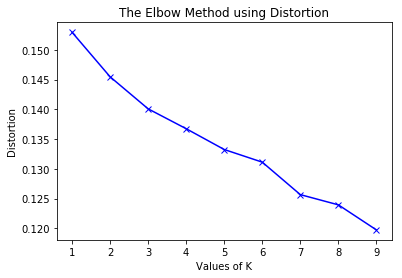

In [20]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

There is no clear elbow visible. At 8 there is a small elbow, but this value is too high for clustering. Therefore, we will use 4 clusters instead. Now let's cluster each location point.

In [21]:
clusterNum = 4
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels) 

[0 1 1 2 2 2 1 2 2 2 1 0 1 1 2 1 1 0 2 1 3 0 3 0 1 2 3 2 2 0 2 0 2 2 2 1 2
 2 1 2 1 2 3 0 2 2 2 1 1 2 2 3]


Now we have the clusters for each location point. We can add this to the already existing dataframe.
Because we want to plot those clusters on a map later on, we want the coordinates of each location point as well.

In [22]:
relevant_lat = []
relevant_long = []
for ii in relevant_locations:
    lat = list(poland_venues[poland_venues['Location point'] == ii]['Location point Latitude'].unique())
    relevant_lat = relevant_lat + lat
    long = list(poland_venues[poland_venues['Location point'] == ii]['Location point Longitude'].unique())
    relevant_long = relevant_long + long

Now we can insert the coordinates and cluster labels to the already existing dataframe with the most common venues.

In [23]:
# add clustering labels and coordinates
neighborhoods_venues_sorted.insert(loc=1,column='Latitude', value=relevant_lat)
neighborhoods_venues_sorted.insert(loc=2,column='Longitude', value=relevant_long)
neighborhoods_venues_sorted.insert(loc=3,column='Cluster Labels', value=labels)

In [24]:
neighborhoods_venues_sorted

,Location point,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"1,Krakow",50.069234,19.930769,0,Hotel,Hostel,Bakery,Restaurant,Liquor Store,Coffee Shop,Park,Diner,Polish Restaurant,Tea Room
1,"1,Lodz",51.779056,19.446337,1,Pizza Place,Eastern European Restaurant,Coffee Shop,Hotel,Steakhouse,Ice Cream Shop,Supermarket,Clothing Store,Fast Food Restaurant,Mediterranean Restaurant
2,"1,Warsaw",52.245482,21.000152,1,Coffee Shop,Vegetarian / Vegan Restaurant,Italian Restaurant,Café,Bistro,Gastropub,Furniture / Home Store,Opera House,Supermarket,Indie Movie Theater
3,"10,Krakow",50.060585,19.937697,2,Café,Polish Restaurant,Italian Restaurant,Plaza,Church,Restaurant,Hotel,Ice Cream Shop,Pub,Coffee Shop
4,"10,Lodz",51.765542,19.457162,2,Bar,Restaurant,Nightclub,Pub,Café,Turkish Restaurant,Coffee Shop,Italian Restaurant,Vegetarian / Vegan Restaurant,Hostel
5,"10,Poznan",52.406362,16.925152,2,Café,Italian Restaurant,Pub,Coffee Shop,Pizza Place,Electronics Store,Japanese Restaurant,Hotel,Theater,Dessert Shop
6,"10,Warsaw",52.232779,21.010328,1,Coffee Shop,Theater,Fast Food Restaurant,Café,Hotel,Beer Bar,Italian Restaurant,Cocktail Bar,Bar,Polish Restaurant
7,"11,Krakow",50.060585,19.944625,2,Café,Nightclub,Bar,Church,Burger Joint,Italian Restaurant,Hostel,Hotel,History Museum,Plaza
8,"11,Poznan",52.406362,16.934895,2,Café,Polish Restaurant,Pub,Beer Bar,Restaurant,Bar,Sushi Restaurant,Burger Joint,Mexican Restaurant,Ice Cream Shop
9,"11,Warsaw",52.232779,21.020504,2,Café,Cocktail Bar,Sushi Restaurant,Pizza Place,Bookstore,Boutique,Ice Cream Shop,Vegetarian / Vegan Restaurant,Coffee Shop,Gastropub


## 5. Name the clusters and visualize them on the map

Now we have clustered each location point, we need to know what each cluster represents. Therefore, we will get the 3 most common venues for each location point. We will combine those venues if the cluster type is the same. In this way, we get an overview of the most common venues in each cluster.

In [25]:
dummy =[]
venues_per_cluster =[]
for ii in range(clusterNum):
    dummy = dummy + (list(neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels']==ii]['1st Most Common Venue'])
                     + list(neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels']==ii]['2nd Most Common Venue'])
                     + list(neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels']==ii]['3rd Most Common Venue']))
    venues_per_cluster = venues_per_cluster + [sorted(Counter(dummy).items())]
print(venues_per_cluster)

[[('Bakery', 1), ('Café', 4), ('Clothing Store', 2), ('Coffee Shop', 1), ('Hostel', 5), ('Hotel', 8), ('Italian Restaurant', 1), ('Polish Restaurant', 1), ('Restaurant', 1)], [('Bakery', 1), ('Bar', 1), ('Café', 4), ('Clothing Store', 4), ('Coffee Shop', 8), ('Dance Studio', 1), ('Eastern European Restaurant', 2), ('Electronics Store', 1), ('Fast Food Restaurant', 1), ('Hostel', 5), ('Hotel', 14), ('Indian Restaurant', 1), ('Italian Restaurant', 7), ('Park', 2), ('Pizza Place', 5), ('Platform', 1), ('Plaza', 1), ('Polish Restaurant', 2), ('Pub', 1), ('Restaurant', 3), ('Supermarket', 1), ('Sushi Restaurant', 1), ('Theater', 1), ('Vegetarian / Vegan Restaurant', 1)], [('Bakery', 3), ('Bar', 4), ('Beer Bar', 2), ('Café', 25), ('Clothing Store', 4), ('Cocktail Bar', 1), ('Coffee Shop', 11), ('Dance Studio', 1), ('Eastern European Restaurant', 2), ('Electronics Store', 1), ('Fast Food Restaurant', 1), ('Food Truck', 1), ('Hostel', 6), ('Hotel', 24), ('Ice Cream Shop', 1), ('Indian Restaura

In order to get a clear overview of the most common venues in each cluster, we will create barcharts for each clusters showing the most common venues of each cluster.

<Figure size 432x288 with 0 Axes>

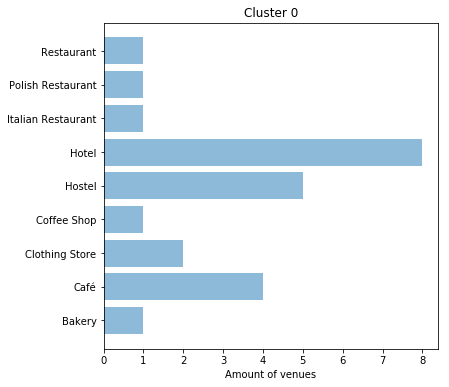

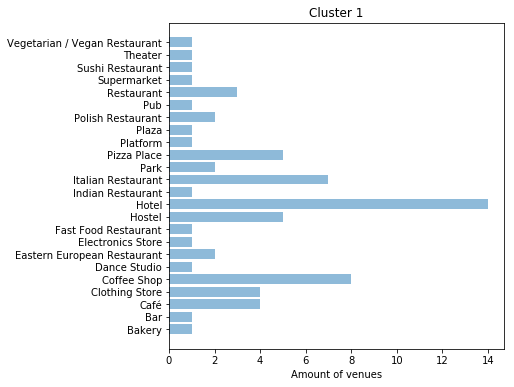

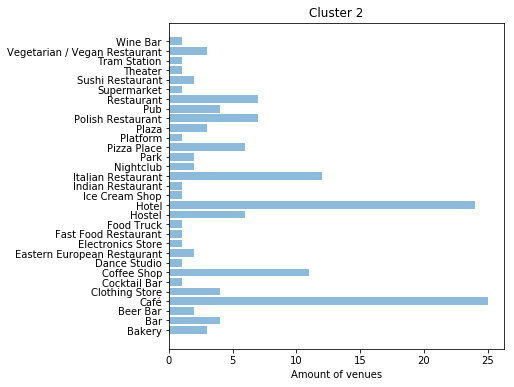

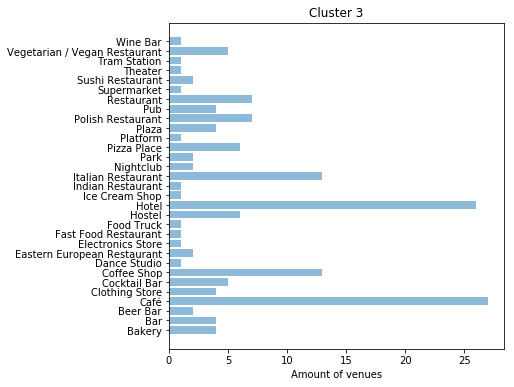

In [26]:
fig = plt.figure()

for xx in list(np.arange(0,4,1)):
    categories = ()
    amount = []
    for ii in venues_per_cluster[xx]:
        categories = categories+(ii[0],)
        amount = amount + [ii[1]]
        
    y_pos = np.arange(len(categories))
    plt.figure(figsize=(6, 6))   
    
    plt.barh(y_pos, amount, align='center', alpha=0.5)
    plt.yticks(y_pos, categories)
    plt.xlabel('Amount of venues')
    plt.title('Cluster ' + str(xx))

    plt.show()

Using the barcharts we can label the clusters. We label cluster 0 as ‘Everyday life’, cluster 1 as ‘Multiple Social Venues’, cluster 2 as ‘Accommodation’ and cluster 3 as ‘Restaurants’. Now we can map the location points on a map using the folium library.

In [27]:
# create map
map_clusters = folium.Map(location=[51.324468, 19.584762], zoom_start=7)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_venues_sorted['Latitude'], neighborhoods_venues_sorted['Longitude'], neighborhoods_venues_sorted['Location point'], neighborhoods_venues_sorted['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters